# Anime Recommended System

## Team member
  - Nguyễn Quốc Bảo - 19133002
  - Võ Hoàng Khả Diệu - 19133014
  
  This notebook explains how to use the [Anime Datasets]() to build a movie recommender using [collaborative filtering](https://en.wikipedia.org/wiki/Recommender_system#Collaborative_filtering) with [Spark's Alternating Least Saqures](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.recommendation.ALS.html) implementation. It is organised in two parts. The first one is about getting and parsing movies and ratings data into Spark RDDs. The second is about building and using the recommender and persisting it for later use in our on-line recommender system. 

## Getting and processing the data

In [2]:
import findspark
findspark.init()
findspark.find()
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.functions import col,isnan, when, count
import pandas as pd

In [3]:
spark = SparkSession.builder \
    .appName("Anime recommendation") \
    .enableHiveSupport() \
    .getOrCreate()

In [5]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

### Loading and parsing datasets

Now we are ready to read in each of the files and create an RDD consisting of parsed lines.

Each line in the rating_change dataset (`rating_change.csv`) is formatted as:  

`user_id, anime_id, rating` 

(The `rating_change.csv` was handled and processed data from `rating.csv` at EDA part.)

Each line in the animes (`anime.csv`) dataset is formatted as:  

`anime_id, name, genre`

In [6]:
datasets_path = os.path.join('../data')
rating_file_path = os.path.join(datasets_path, 'rating_change.csv');
rating_raw_RDD = sc.textFile(rating_file_path)
anime_file_path = os.path.join(datasets_path, 'anime.csv')
anime_raw_RDD = sc.textFile(anime_file_path)

So let's load the raw ratings data. We need to filter out the header, included in each file.

In [9]:
rating_data_raw_header = rating_raw_RDD.take(1)[0]
anime_data_raw_header = anime_raw_RDD.take(1)[0]

Now we can parse the raw data into a new RDD.  

In [10]:
rating_RDD = rating_raw_RDD.filter(lambda line: line!=rating_data_raw_header)\
    .map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]), int(tokens[1]), int(tokens[2]))).cache()
anime_title_RDD = anime_raw_RDD.filter(lambda line: line!=anime_data_raw_header)\
    .map(lambda line: line.split(",")).map(lambda x: (int(x[0]), x[1])).cache()

Count and first 5 rows in each RDD

In [23]:
rating_RDD.count()

5868892

In [20]:
rating_RDD.take(5)

[(1, 8074, 5), (1, 11617, 5), (1, 11757, 5), (1, 15451, 5), (2, 11771, 5)]

In [21]:
anime_title_RDD.count()

12294

In [12]:
anime_title_RDD.take(5)

[(32281, 'Kimi no Na wa.'),
 (5114, 'Fullmetal Alchemist: Brotherhood'),
 (28977, 'Gintama°'),
 (9253, 'Steins;Gate'),
 (9969, 'Gintama&#039;')]

Create dataframe from rdd for process recommendation system by spark dataframe

In [20]:
ratings_df = spark.createDataFrame(data = rating_RDD, schema = ["user_id", "anime_id", "rating"])

In [19]:
ratings_df.show(5)

+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|      1|    8074|     5|
|      1|   11617|     5|
|      1|   11757|     5|
|      1|   15451|     5|
|      2|   11771|     5|
+-------+--------+------+
only showing top 5 rows



In [ ]:
animes_df = spark.createDataFrame(data = anime_title_RDD, sc)

## Building and using the Recommended system

### Collaborative Filtering - ALS

Split rating data into 3 parts: Training, Validation and Testing with radio 6:2:2

In [21]:
(training, validation, testing) = ratings_df.randomSplit([0.6, 0.2, 0.2])

#### Build & Training model

Now we will proceed training phrase

In training phrase, we will tuning parameters to choose the best model with Root Mean Squared Error (RMSE) is lowest possible.

The parameters we used in this model: `ranks`, `maxIters`, `regParams`

In [28]:
ranks = [8, 12]
maxIters = [5, 10]
regParams = [0.1, 0.01]
bestParams = [-1, -1, -1]
min_error = float('inf')

In [23]:
from datetime import datetime
for rank in ranks:
    for maxIter in maxIters:
        for regParam in regParams:
            start_time = datetime.now()
            als = ALS(rank=rank, maxIter=maxIter, regParam=regParam, userCol="user_id", itemCol="anime_id", ratingCol="rating")
            model = als.fit(training)
            model.setColdStartStrategy("drop");
            predictions = model.transform(validation)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                           predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            end_time = datetime.now()
            if(rmse < min_error):
                min_error = rmse
                bestParams = [rank, maxIter, regParam]
            print('Execute time {}'.format(end_time - start_time))
            print('Rank: %s, maxIter: %s, regParam: %s, RMSE: %s' % (rank, maxIter, regParam, str(rmse)))

Execute time 0:01:24.056598
Rank: 8, maxIter: 5, regParam: 0.1, RMSE: 0.9495164208810919
Execute time 0:01:01.960883
Rank: 8, maxIter: 5, regParam: 0.01, RMSE: 0.9835134803838274
Execute time 0:01:13.352696
Rank: 8, maxIter: 10, regParam: 0.1, RMSE: 0.9454070515172769
Execute time 0:01:09.533617
Rank: 8, maxIter: 10, regParam: 0.01, RMSE: 0.9849855122987078
Execute time 0:01:08.960076
Rank: 12, maxIter: 5, regParam: 0.1, RMSE: 0.9561809928480054
Execute time 0:01:04.636614
Rank: 12, maxIter: 5, regParam: 0.01, RMSE: 1.003703459426759
Execute time 0:01:16.951480
Rank: 12, maxIter: 10, regParam: 0.1, RMSE: 0.9449057402086288
Execute time 0:01:20.487655
Rank: 12, maxIter: 10, regParam: 0.01, RMSE: 1.0124456615310247


After tuning parameters, we got the best parameter for final model.

In [31]:
bestParams

[12, 10, 0.1]

The above values are respectively: `rank`, `maxIter` and `regParam`

#### Build & Test the final model

Use the best params to build the final model

In [32]:
start_time = datetime.now()
best_ALS = ALS(rank=bestParams[0], maxIter=bestParams[1], regParam=bestParams[2], userCol="user_id", itemCol="anime_id", ratingCol="rating")
best_model = als.fit(testing)
end_time = datetime.now()
print('Execute time {}'.format(end_time - start_time))

Execute time 0:00:45.731202


Now we will test the final model by our testing data

In [33]:
best_model.setColdStartStrategy("drop");
predictions = best_model.transform(testing)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                               predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.6266904331154174


Although we aim at building an on-line anime recommender, now that we know how to have our recommender model ready, we can give it a try providing some anime recommendations. This will help us coiding the recommending engine later on when building the web service, and will explain how to use the model in any other circumstances.

When using collaborative filtering, getting recommendations is not as simple as predicting for the new entries using a previously generated model. Instead, we need to train again the model but including the new user preferences in order to compare them with other users in the dataset. That is, the recommender needs to be trained every time we have new user ratings (although a single model can be used by multiple users of course!). This makes the process expensive, and it is one of the reasons why scalability is a problem (and Spark a solution!). Once we have our model trained, we can reuse it to obtain top recomendations for a given user or an individual rating for a particular movie. These are less costly operations than training the model itself.    

#### Using the model for recommended system

Here, we will try to build a feature to recommend top 10 anime for a user (Example: user_id = 215)

In [58]:
user_subset = ratings_df.where(ratings_df.user_id == 215)
user_subset_recs = model.recommendForUserSubset(user_subset, 10)
list_user_predictions = list(user_subset_recs.select('recommendations').toPandas()['recommendations'])
user_prediction_rdd = sc.parallelize(list_user_predictions[0])

`recommendForUserSubset` is a function of ALS is provided by package `ml`. It will take out the top 10 anime with the highest rating prediction and recommend to users.

In [61]:
#Join name of Anime into a new list
list_complete_user_prediction = user_prediction_rdd.join(anime_title_RDD) \
    .map(lambda x: (x[0], x[1][1], x[1][0])) \
    .takeOrdered(10, key=lambda x: -x[2])

In [71]:
# Change list to dataframe
user_subset_recs_columns = ["anime_id","name", "rating"]
user_subset_recs_DF = spark.createDataFrame(data=list_complete_user_prediction, schema = user_subset_recs_columns)

In [125]:
# Show output
print("Top 10 anime recommended for userID is " + str(user_subset.collect()[0][0]))
print(user_subset_recs_DF.show(10))

Top 10 anime recommended for userID is 215
+--------+--------------------+-----------------+
|anime_id|                name|           rating|
+--------+--------------------+-----------------+
|    7416|              Socket|6.557953357696533|
|   32400|           KochinPa!|6.261995792388916|
|   29978|                 001|6.244216442108154|
|   29995|The Embryo Develo...|6.110090732574463|
|    7485|      Urashima Tarou|6.042207717895508|
|   22059|Kakumeiteki Broad...|5.638498306274414|
|   22615|Kero Kero Keroppi...|5.526596546173096|
|   22445|Hello Kitty no Ya...|5.526596546173096|
|   17985|Kero Kero Keroppi...|5.526596546173096|
|   22607|Ahiru no Pekkle n...|5.526596546173096|
+--------+--------------------+-----------------+

None


The above result is the top 10 anime with highest rating prediction for user 215

#### Persisting the model

In [122]:
model_path = os.path.join('model') + "/als_model"
model.save(model_path)

### Content-base Filtering

With Content-base, we will sklearn package for process and handle data and build model for prediction.

In [7]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import numpy as np
import math

#### Loading and processing data

In [8]:
#Reading anime file:
animeDF = pd.read_csv(anime_file_path, sep=',', encoding='latin-1')
animeDF.dropna(inplace=True)
list_anime = animeDF["anime_id"].to_numpy()
#Get n_items
n_items = animeDF.shape[0]
print("Number of item: ", n_items)

Number of item:  12017


In [68]:
#Reading rating file:
ratingDF = pd.read_csv(rating_file_path, sep=',', encoding='latin-1')
ratingDF.dropna(inplace=True)
ratingDF = ratingDF[ratingDF.anime_id.isin(animeDF.anime_id)]
ratingDF.shape

(5868859, 3)

Split rating data into 2 parts: Training and Testing with radio 8:2

In [10]:
# Chia tập train & tập test theo tỉ lệ 8 : 2
train, test = train_test_split(ratingDF, test_size=0.2)

#### Build Item profile use TF-IDF

An important job in a content-based recommendation system is to build a profile for each item, i.e. a feature vector for each item. Because we are based on the genre of the movie to build the profile so we just need to care about the genre of movies

We will build feature vector for each item based on anime genre matrix and feature TF-IDF

In [11]:
tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,2)
                                             for c in combinations(s.split(', '), r=i)))
tfidf = tf.fit_transform(animeDF['genre']).toarray()
print("Number of genre: ", tfidf.shape)

Number of genre:  (12017, 43)


After this step, each row of TF-IDF corresponds to the feature vector of a anime.

In [12]:
tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.29453722, 0.3158063 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.262021  , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Next step, for each user, we need to find what animes that user has rated, and the value of those ratings.

In [13]:
def get_items_rated_by_user(rate_matrix, user_id):
    """
    return (items_index, scores)
    """
    y = rate_matrix[:,0] # all users
    # item indices rated by user_id
    ids = np.where(y == user_id)[0]
    item_ids = rate_matrix[ids,1]
    items_index = get_items_index(item_ids)
    #Rated score of user-item
    scores = rate_matrix[ids, 2]
    return (items_index, scores)

In [14]:
def get_items_index(item_ids):
    items_index = []
    for i in item_ids:
        item = np.where(list_anime == i)[0][0]
        items_index.append(item)
    return np.array(items_index)

In [15]:
def get_user_index(list_users, user_id):
    user_index = np.where(list_users == user_id)
    return user_index[0][0]

Countinues, we will build a loss function used Ridge Regression with linear model
                            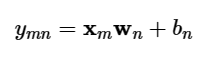

In [16]:
list_users = train["user_id"].unique()
#list_users = ratingDF["user_id"].unique()
n_users = list_users.shape[0]
rate_train = train.values
d = tfidf.shape[1] # data dimension
W = np.zeros((d, n_users), dtype="float32")
b = np.zeros((1, n_users), dtype="float32")

Now, we can find the Ridge Regression coefficients for each user.

In [17]:
for n in list_users:
    user_index = get_user_index(list_users, n)
    items_index, scores = get_items_rated_by_user(rate_train, n)
    clf = Ridge(alpha=0.01, fit_intercept  = True)
    Xhat = tfidf[items_index, :]
    clf.fit(Xhat, scores)
    W[:, user_index] = clf.coef_
    b[0, user_index] = clf.intercept_

After calculating the W and b coefficients, the ratings for each item are predicted by calculating:

In [18]:
Yhat = tfidf.dot(W) + b

In [19]:
Yhat

array([[4.44175871, 4.34551252, 4.79630019, ..., 4.        , 2.        ,
        5.        ],
       [4.78237046, 3.85528238, 3.59884363, ..., 4.        , 2.        ,
        5.        ],
       [2.48299593, 2.40615728, 3.87882531, ..., 4.        , 2.        ,
        5.        ],
       ...,
       [0.76868951, 2.9963994 , 3.32303715, ..., 4.        , 2.        ,
        5.        ],
       [0.76868951, 2.9963994 , 3.32303715, ..., 4.        , 2.        ,
        5.        ],
       [0.76868951, 2.9963994 , 3.32303715, ..., 4.        , 2.        ,
        5.        ]])

Here is an example with a user whose id is 3.

In [20]:
#Example
user_id = 3
user_index = get_user_index(list_users, user_id)
ids, scores = get_items_rated_by_user(rate_train, user_id)
print('Rated movies ids:', ids)
print('True ratings:', scores)
print('Predicted ratings:', Yhat[ids, user_index])

Rated movies ids: [1413 3287   40 1886 1104  841   58 2892 2945  723  804  704    1  118
 3032  101 5876  440  122 3593 1518 2035  708  138   14 4212 1013  206
 3342  324  971 1220 1620 3219  339 2132  374 3191  199 1834  141  775
  643 4211  687   57  127  365 2922  342 2164 1130 3632   86  268   79
 1067  186 1213 1709  288 1558  616  411 2656   15]
True ratings: [3 1 5 1 3 3 5 2 2 2 4 2 5 4 2 5 1 3 5 3 3 3 4 3 4 2 3 5 2 3 2 2 1 2 3 2 2
 2 1 2 3 3 3 1 2 5 4 3 2 3 2 2 2 5 5 4 3 2 2 1 3 2 5 3 2 5]
Predicted ratings: [3.03460312 2.18815671 4.87929876 1.00643351 3.10536386 3.2384853
 4.18232502 2.18469668 3.1873412  3.58031666 2.86347938 2.51301026
 3.57995944 2.99388548 2.34020228 3.77778439 1.32255416 4.01435145
 4.18232502 3.05125988 2.76320355 2.18469668 3.40540345 4.09154111
 4.15035834 2.02373474 3.1873412  4.66376317 2.47195026 3.35994113
 2.05754858 1.95956373 1.09712119 3.05125988 2.86413153 2.86347938
 3.00359026 2.09849571 1.42989549 2.02373474 3.37920833 3.63969855
 2.5130102

#### Model evaluation

To evaluate the found model, we aslo use the Root Mean Squared Error (RMSE), which is the square root of the mean squared error. The error is calculated as the difference of true rating and predicted rating:

In [101]:
def evaluate(Yhat, rates, W, b, list_users):
    se = 0
    cnt = 0
    for n in list_users:
        user_index = get_user_index(list_users, n)
        ids, scores_truth = get_items_rated_by_user(rates, n)
        scores_pred = Yhat[ids, user_index]
        e = scores_truth - scores_pred 
        se += (e*e).sum(axis = 0)
        cnt += e.size 
    return math.sqrt(se/cnt)

In [102]:
list_users_train = train["user_id"].unique()
print('RMSE for training:', evaluate(Yhat, rate_train, W, b, list_users_train))

RMSE for training: 0.8021310281350346


In [103]:
rate_test = test.values
list_users_test = test["user_id"].unique()
print('RMSE for test    :', evaluate(Yhat, rate_test, W, b, list_users_test))

RMSE for test    : 1.7823851453314659


So, with the training set, the error is about 0.8 stars; with the test set, the error is a bit larger, about 1.77. We see that this result is not really good because we have simplified the model too much

#### Using the model for recommended system

We will try recommend top 20 anime for a user with Content-base-filtering (Example: user_id = 3)

In [112]:
user_id = 3
user_direct_rating = Yhat[:, user_id]
top_10 = user_direct_rating.argsort()[-20:][::-1]

In [113]:
animeDF.iloc[top_10]

,anime_id,name,genre,type,episodes,rating,members
4109,18851,Fate/kaleid liner PrismaâIllya: Undoukai de ...,"Comedy, Fantasy, Magic",OVA,1,6.80,22543
2889,5520,Onegai My Melody Sukkiriâª,"Comedy, Fantasy, Magic",TV,52,7.14,966
5579,17681,Zettai Bouei Leviathan,"Comedy, Fantasy, Magic",TV,13,6.42,18202
2659,32094,Reikenzan: Hoshikuzu-tachi no Utage,"Comedy, Fantasy, Magic",TV,12,7.20,30153
5001,5938,OnegaiâªMy Melody Kiraraâ,"Comedy, Fantasy, Magic",TV,52,6.58,741
6504,19397,Zettai Bouei Leviathan: Mini Takibi Gekijou,"Comedy, Fantasy, Magic",Special,13,6.09,1203
8285,32237,Burutabu-chan,"Comedy, Fantasy, Magic",TV,Unknown,5.00,37
2634,367,Akazukin Chacha OVA,"Comedy, Fantasy, Magic",OVA,3,7.20,1659
2803,2489,Onegai My Melody,"Comedy, Fantasy, Magic",TV,52,7.16,3633
1944,4114,Onegai My Melody: Kuru Kuru Shuffle!,"Comedy, Fantasy, Magic",TV,52,7.40,1962
